We load in the MNIST dataset and split it into training and test sets. We also normalize the data.

Since I'm writing this on an M1 Laptop, I also enable GPU acceleration.

In [11]:
import torch
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

if (torch.backends.mps.is_available() and torch.backends.mps.is_built()):
    device = torch.device("mps")
    kwargs = {'num_workers': 4, 'pin_memory': True}
    print("Using MPS")
else:
    device = torch.device("cpu")
    kwargs = {}
    print("Using CPU")
device = torch.device("cpu")

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
]))

mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
]))

train_loader = torch.utils.data.DataLoader(dataset=mnist_train, batch_size=64, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(dataset=mnist_test, batch_size=100, shuffle=True, **kwargs)

n_epochs = 3



Using MPS


torch.Size([64, 1, 28, 28])


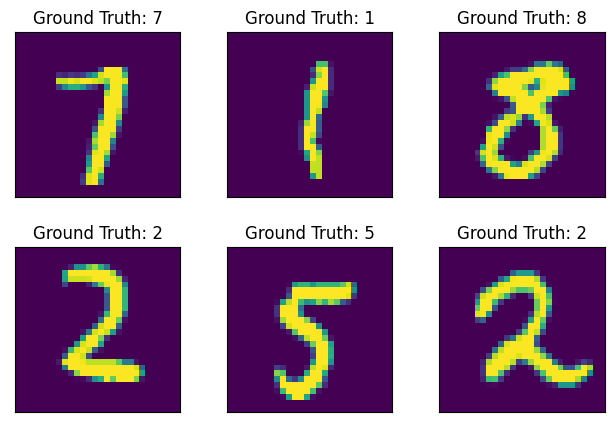

In [12]:
import matplotlib.pyplot as plt

examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0])
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
print(example_data.shape)

We create a simple CNN with 2 convolutional layers and 2 fully connected layers. We use ReLU as the activation function and stochastic gradient descent as the optimizer.
This provides a basic starting point for image classification.

In [30]:
import torch.nn as nn

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Conv2d(1, 10, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.layer2 = nn.Conv2d(10, 20, kernel_size=5)
        self.layer3 = nn.Linear(28*28, 120)
        self.layer4 = nn.Linear(120, 50)
        self.layer5 = nn.Linear(50, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.relu(self.layer3(x))
        x = self.relu(self.layer4(x))
        x = self.softmax(self.layer5(x))
        return x

model = NeuralNetwork().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [37]:
train_losses = []
train_counter = []

def train(epoch):
    model.train()
    running_loss = 0.0
    for i, (data,target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = nn.CrossEntropyLoss()(outputs, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 10 == 0:
            print('Epoch: %d, Batch: %5d, Loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
            train_losses.append(loss.item())
            train_counter.append((i*64) + ((epoch-1)*len(train_loader.dataset)))



In [38]:
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

def test():
    model.eval()
    correct = 0
    loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)

            output = model(data)
            loss += nn.CrossEntropyLoss()(output, target).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    loss /= len(test_loader.dataset)
    test_losses.append(loss)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [39]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()
print("Done")


Test set: Average loss: 0.0016, Accuracy: 9519/10000 (95%)

Epoch: 2, Batch:     1, Loss: 0.001
Epoch: 2, Batch:    11, Loss: 0.013
Epoch: 2, Batch:    21, Loss: 0.017
Epoch: 2, Batch:    31, Loss: 0.019
Epoch: 2, Batch:    41, Loss: 0.015
Epoch: 2, Batch:    51, Loss: 0.014
Epoch: 2, Batch:    61, Loss: 0.022
Epoch: 2, Batch:    71, Loss: 0.015
Epoch: 2, Batch:    81, Loss: 0.013
Epoch: 2, Batch:    91, Loss: 0.017
Epoch: 2, Batch:   101, Loss: 0.014
Epoch: 2, Batch:   111, Loss: 0.019
Epoch: 2, Batch:   121, Loss: 0.014
Epoch: 2, Batch:   131, Loss: 0.015
Epoch: 2, Batch:   141, Loss: 0.012
Epoch: 2, Batch:   151, Loss: 0.016
Epoch: 2, Batch:   161, Loss: 0.013
Epoch: 2, Batch:   171, Loss: 0.018
Epoch: 2, Batch:   181, Loss: 0.014
Epoch: 2, Batch:   191, Loss: 0.017
Epoch: 2, Batch:   201, Loss: 0.017
Epoch: 2, Batch:   211, Loss: 0.017
Epoch: 2, Batch:   221, Loss: 0.011
Epoch: 2, Batch:   231, Loss: 0.014
Epoch: 2, Batch:   241, Loss: 0.014
Epoch: 2, Batch:   251, Loss: 0.017
Epo

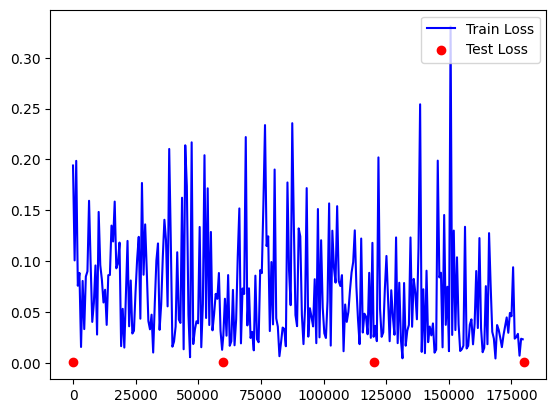

In [25]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')


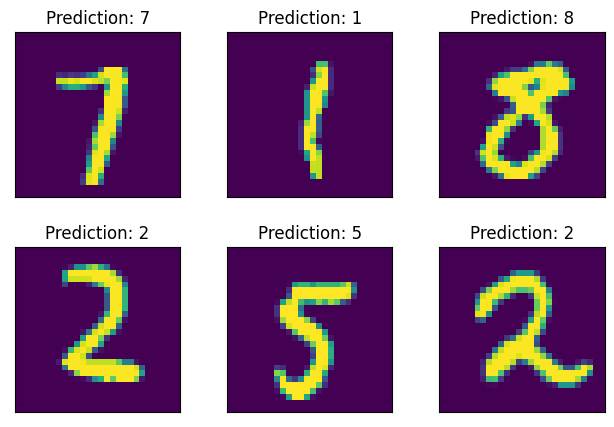

In [24]:
def read_numbers():
    with torch.no_grad():
        output = model(example_data.to(device))
        for i in range(6):
              plt.subplot(2,3,i+1)
              plt.tight_layout()
              plt.imshow(example_data[i][0])
              plt.title("Prediction: {}".format(
                output.data.max(1, keepdim=True)[1][i].item()))
              plt.xticks([])
              plt.yticks([])

read_numbers()